In [39]:
# !pip install lightgbm
# !pip install yellowbrick
# !pip install ipywidgets
# !pip install pandas-profiling
# !pip install joblib
# !jupyter nbextension enable --py widgetsnbextension

In [40]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

import joblib
from google.colab import files

%matplotlib inline

In [41]:
database = sqlite3.connect(os.path.join(os.getcwd(), "fypdbmain.sqlite"))

In [42]:
tickers = {
    "EVs": "TSLA",
    "Finance": "MS",
    "Tech": "GOOGL"
}

categories = ["EVs","Finance","Tech"]

tableName = {
    "EVs": "evDataAggr",
    "Finance": "financeDataAggr",
    "Tech": "techDataAggr"
}


In [43]:
def load_datasets(tickers, categories):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    for category in categories:
      ticker = tickers[category]
      #ToDo make this line general
      tweet_df = pd.read_sql_query(f"SELECT * from {tableName[category]}",database)
      tweet_df = tweet_df.drop(columns = ['category'])
      tweet_df["date"] = tweet_df["date"].astype("datetime64")
      tweet_df["count"] = tweet_df["count"].astype("int32")
      tweet_df["neg_count"] = tweet_df["neg_count"].astype("int32")
      tweet_df["neu_count"] = tweet_df["neu_count"].astype("int32")
      tweet_df["pos_count"] = tweet_df["pos_count"].astype("int32")
      tweet_df["neg_score"] = tweet_df["neg_score"].astype("float64")
      tweet_df["neu_score"] = tweet_df["neu_score"].astype("float64")
      tweet_df["pos_score"] = tweet_df["pos_score"].astype("float64")
      tweet_df["wt_neg"] = tweet_df["wt_neg"].astype("float64")
      tweet_df["wt_neu"] = tweet_df["wt_neu"].astype("float64")
      tweet_df["wt_pos"] = tweet_df["wt_pos"].astype("float64")
      #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])

      if(ticker!='GOOGL'):
        tweet_df["neg_count"] = -1 * tweet_df["neg_count"]
        tweet_df["neg_score"] = -1 * tweet_df["neg_score"]
        tweet_df["wt_neg"] = -1 * tweet_df["wt_neg"]
        tweet_df["neu_count"] = -1 * tweet_df["neu_count"]
        tweet_df["neu_score"] = -1 * tweet_df["neu_score"]
        tweet_df["wt_neu"] = -1 * tweet_df["wt_neu"]
        tweet_df["pos_count"] = -1 * tweet_df["pos_count"]
        tweet_df["pos_score"] = -1 * tweet_df["pos_score"]
        tweet_df["wt_pos"] = -1 * tweet_df["wt_pos"]

      tweet_dfs[ticker] = tweet_df.copy(deep=True)

      stock_df = pd.read_sql_query(f"SELECT * from stockDataAggr where category ='{category}'",database)
      stock_df = stock_df.drop(columns = ['category', 'ticker','aggrPercent'])

      stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
      stock_df["open"] = stock_df["open"].astype("float64")
      stock_df["close"] = stock_df["close"].astype("float64")
      stock_df["high"] = stock_df["high"].astype("float64")
      stock_df["low"] = stock_df["low"].astype("float64")

      stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
      stock_dfs[ticker] = stock_df.copy(deep=True)
      del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [44]:
tweet_dfs, stock_dfs = load_datasets(tickers, categories)

In [45]:
tweet_dfs["MS"]

,date,neg_count,neu_count,pos_count,neg_score,neu_score,pos_score,wt_neg,wt_neu,wt_pos,count
0,2022-08-02,-766,-127,-303,-336.0,-115.406570,-196.611622,-239.981812,-152.470932,-293.251112,320
1,2022-08-01,-427,-83,-150,-194.0,-69.494362,-115.738205,-174.767426,-77.543838,-154.309587,195
2,2022-08-03,-1359,-451,-497,-411.0,-285.696716,-395.129700,-274.173561,-417.545763,-535.736023,405
3,2022-08-04,-1479,-361,-744,-374.0,-234.666542,-372.979546,-317.353912,-471.263652,-580.721989,427
4,2022-08-05,-1183,-358,-405,-420.0,-226.413116,-297.240101,-229.346766,-323.883955,-422.728630,436
...,...,...,...,...,...,...,...,...,...,...,...
238,2023-03-27,-616,-148,-284,-184.0,-148.681401,-274.666202,-192.652397,-234.922952,-482.123691,318
239,2023-03-28,-187,-54,-97,-36.0,-47.810618,-95.097759,-44.091623,-75.500702,-112.091591,47
240,2023-03-29,-498,-126,-172,-200.0,-123.980578,-195.046607,-178.972815,-142.884097,-225.294882,203
241,2023-03-30,-522,-104,-277,-141.0,-109.790652,-237.557411,-174.651938,-117.151378,-262.639870,207


In [46]:
stock_dfs["MS"]

,date,open,close,high,low
0,2022-08-01,83.660004,84.089996,84.540001,83.010002
1,2022-08-02,83.330002,83.529999,84.589996,82.959999
2,2022-08-03,84.680000,85.050003,85.589996,84.120003
3,2022-08-04,85.199997,85.360001,85.650002,84.800003
4,2022-08-05,84.989998,86.129997,86.709999,84.709999
...,...,...,...,...,...
238,2023-03-27,86.059998,84.639999,86.320000,84.360001
239,2023-03-28,84.559998,84.879997,85.169998,83.930000
240,2023-03-29,85.930000,86.239998,86.349998,85.349998
241,2023-03-30,87.260002,86.110001,87.610001,85.459999


In [47]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
            
        temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
        temp_stock_df = stock_dfs[ticker].copy(deep=True)

        temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
        temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
        
        
        merged_dfs[ticker] = temp_merged_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
        
        del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [48]:
def normalize_datasets(categories, tickers, merged_dfs, reduced=False, output_label='close'):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        
        ticker = tickers[category]
        temp_norm_df = merged_dfs[ticker].copy(deep=True)
        
        temp_norm_df = temp_norm_df.drop(columns=['date'])

        temp_norm_df = scaler.fit_transform(temp_norm_df)

        if(reduced == False):

          temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                'count','neg_score','neu_score', 'pos_score', \
                                                                'wt_neg', 'wt_neu', 'wt_pos', \
                                                                'neg_count', 'neu_count', 'pos_count'])
        else:
          #columns = ['open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]
          columns = ['open', 'prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]
          temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
        
        
        norm_dfs[ticker] = temp_norm_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
        
        del temp_norm_df
            
    return norm_dfs

In [49]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (243, 15) 

Data dimensions for MS: (243, 15) 

Data dimensions for GOOGL: (243, 15) 



In [50]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        ticker=tickers[category]
        plt.figure(figsize=(10,6))
        sns.heatmap(norm_dfs[ticker].corr('spearman'),cmap='RdYlGn',annot=True, linewidths=0.2)
        plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)

        plt.show()

In [51]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

In [52]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [53]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [54]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled, dates, ticker,output_label='close'):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    print("Predicted","\t","Value")
    for i in range(len(predicted)):
      print(predicted[i],"\t",test_label[i])
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.figure(figsize=(15, 10))
    plt.plot(dates, predicted, color = 'green', label = 'Predicted ' + output_label, linewidth=2)
    plt.plot(dates, test_label, color = 'red', label = 'Actual ' + output_label, linewidth=2)
    plt.title('Stock - '+output_label+' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
    plt.legend(loc='best')
    
    plt.savefig(os.path.join(os.getcwd(),f'images/lightgbm-prediction-graph-{ticker}'), transparent=True, dpi=400)

    plt.show()

In [55]:
def print_feature_importance(model, df_cols, ticker):
    sorted_feature_importance = model.feature_importances_.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(df_cols[sorted_feature_importance], 
             model.feature_importances_[sorted_feature_importance], 
             color = 'turquoise')
    plt.title(f"LightGBM Feature Importance - {ticker}")
    plt.show()

In [56]:
def get_train_test_set(ticker, norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = [output_label], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(merged_dfs[ticker], merged_dfs[ticker][output_label], \
                                                        test_size = 0.2, random_state = 3, shuffle=False)

    
    test_dates = Xd_test['date'] #Collect Test data dates
    
    while len(test_dates) > len(y_test): #in case the array size is higher for dates
        test_dates = test_dates[:-1].copy()
    
    
    del Xd_train, Xd_test, yd_train, yd_test #Run GC
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test, test_dates

In [57]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        ticker=tickers[category]
        # print(output_label)
        unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [58]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels, output_label='close'):
#     params = {'depth': 2,
#               'iterations': 200,
#               'learning_rate': 0.03,
#               'l2_leaf_reg': 3}

    lgb_params = {
    'objective': 'regression',
    'metric': 'l1',  # MAE
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1,
    'max_depth': 3,
    'n_estimators': 500,
    'random_state': 3,
    'n_jobs': 2
}


    model = lgb.LGBMRegressor(**lgb_params,logging_level='Silent')
    
    for category in categories:
        ticker=tickers[category]
        print(f"======CURRENTLY WORKING ON {ticker}======")
        
        X_train, X_test, y_train, y_test, dates = get_train_test_set(ticker, norm_dfs[ticker], 
                                                                      output_label)
        
        model.fit(X_train, y_train)
        joblib.dump(model, 'lightgbm_model_'+ticker+'-'+output_label)

        # Download the saved model file to your local machine
        files.download('lightgbm_model_'+ticker+'-'+output_label)
        
        print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
        print_metrics(model, X_train, X_test, y_test)
        plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker], dates, ticker,output_label)
        
        
        print(f"======FINISHED WORKING ON {ticker}======")

In [59]:
def append_prev_day_value(categories, tickers, merged_dfs, output_label='close'):
    prev_open_dfs = dict()

    column_to_drop = ['count', 'neg_score', 'neu_score', 'pos_score', 'neg_count', 'neu_count', 'pos_count']
    for i in ['low','high','close']:
      if(i != output_label):
        column_to_drop.append(i)

    
    for category in categories:
        ticker = tickers[category]
    
        t_df = merged_dfs[ticker].copy(deep = True)
        t_df = t_df.drop(columns = column_to_drop)

        t_minus1_df = t_df.copy(deep = True).drop(columns = [output_label])
        t_minus1_df = t_minus1_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})

        t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

        t_df = t_df.drop(columns=['wt_neg', 'wt_neu', 'wt_pos'])

        prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

        #prev_open_df = prev_open_df[['date', 'open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]]
        prev_open_df = prev_open_df[['date', 'open', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]]
        
        prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
        
        del prev_open_df #Perform GC

    return prev_open_dfs

# **Predicting Close Value**

In [60]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='close')

both_open_dfs['TSLA']

,date,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,2022-08-02,294.003326,301.276672,-16.876412,-26.904634,-41.171774,300.586670
1,2022-08-03,305.000000,294.003326,-22.682993,-25.073643,-37.357318,307.396667
2,2022-08-04,311.000000,305.000000,-2.331892,-6.009396,-13.196395,308.633331
3,2022-08-05,302.670013,311.000000,-1.167563,-2.196746,-3.635691,288.170013
4,2022-08-06,298.840000,302.670013,-16.216868,-16.855830,-160.879937,289.300000
...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,193.720000,-14.594635,-21.290344,-30.107518,191.809998
238,2023-03-28,192.000000,194.419998,-232.793960,-281.636459,-465.958222,189.190002
239,2023-03-29,193.130005,192.000000,-13.191043,-12.029059,-33.769606,193.880005
240,2023-03-30,195.580002,193.130005,-50.816797,-73.301693,-115.862161,195.279999


In [61]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='close')

Data dimensions for TSLA: (242, 6) 

Data dimensions for MS: (242, 6) 

Data dimensions for GOOGL: (242, 6) 



In [62]:
both_open_norm_dfs['TSLA']

,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,0.915351,0.950208,0.948169,0.984976,0.979141,0.956598
1,0.968051,0.915351,0.930269,0.986030,0.981093,0.990442
2,0.996805,0.968051,0.993008,0.997001,0.993455,0.996587
3,0.956885,0.996805,0.996598,0.999194,0.998347,0.894891
4,0.938530,0.956885,0.950203,0.990759,0.917889,0.900507
...,...,...,...,...,...,...
237,0.438115,0.434760,0.955204,0.988207,0.984802,0.416012
238,0.426518,0.438115,0.282526,0.838391,0.761786,0.402992
239,0.431933,0.426518,0.959531,0.993536,0.982928,0.426300
240,0.443674,0.431933,0.843536,0.958277,0.940923,0.433257


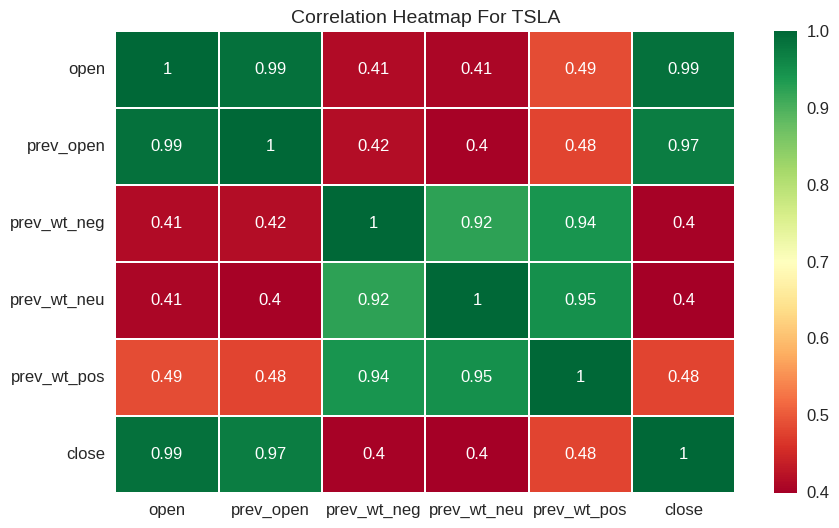

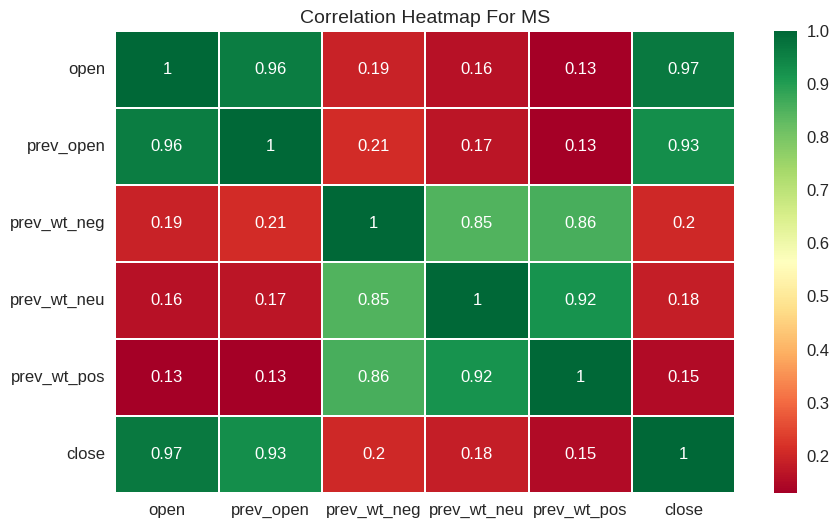

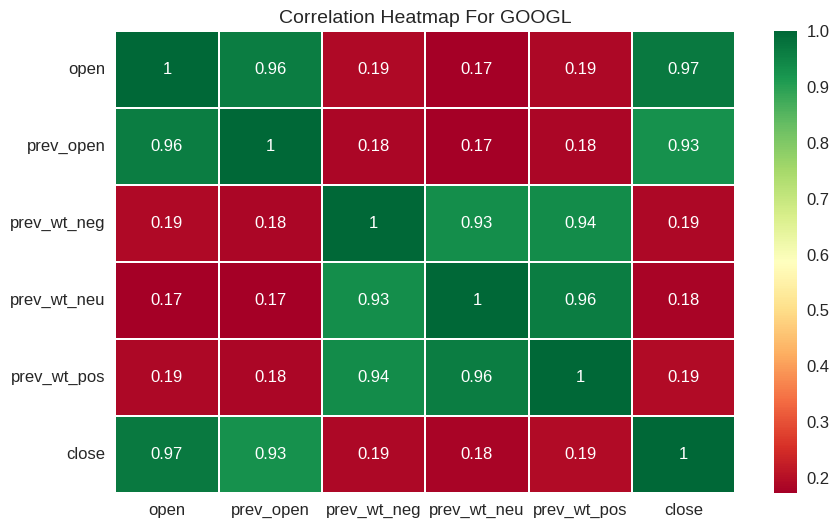

In [63]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

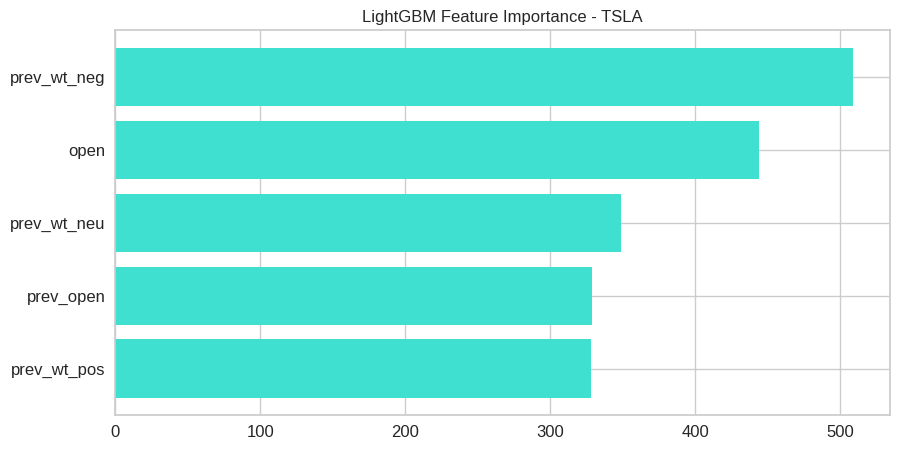

RMSE:			0.031836
MSE:			0.001014
MAE:			0.023195
R2 Score:		0.615913
Adj. R2 Score:		0.605644
Exp. Variance Score:	0.619992
Max Error:		0.087492
Predicted 	 Value
[0.43180455] 	 [0.43564257]
[0.46273486] 	 [0.43285955]
[0.42013248] 	 [0.43007652]
[0.41519129] 	 [0.50268362]
[0.53353135] 	 [0.52748237]
[0.49672677] 	 [0.46685216]
[0.44489581] 	 [0.4980121]
[0.46130135] 	 [0.47082794]
[0.45825276] 	 [0.457211]
[0.51540451] 	 [0.45040253]
[0.51900003] 	 [0.44364374]
[0.44898092] 	 [0.46098797]
[0.44692065] 	 [0.46700132]
[0.43499355] 	 [0.44120864]
[0.45128917] 	 [0.46794552]
[0.4577847] 	 [0.48131397]
[0.44242241] 	 [0.49463275]
[0.5048038] 	 [0.48509097]
[0.50638882] 	 [0.47048008]
[0.40330661] 	 [0.41148987]
[0.43517526] 	 [0.445731]
[0.4489803] 	 [0.43584136]
[0.42322517] 	 [0.43087167]
[0.4266722] 	 [0.42595168]
[0.43680664] 	 [0.39563664]
[0.3623632] 	 [0.36725971]
[0.36526451] 	 [0.32213496]
[0.32336642] 	 [0.32471922]
[0.30641125] 	 [0.32730344]
[0.30144199] 	 [0.32859556]
[0.3511

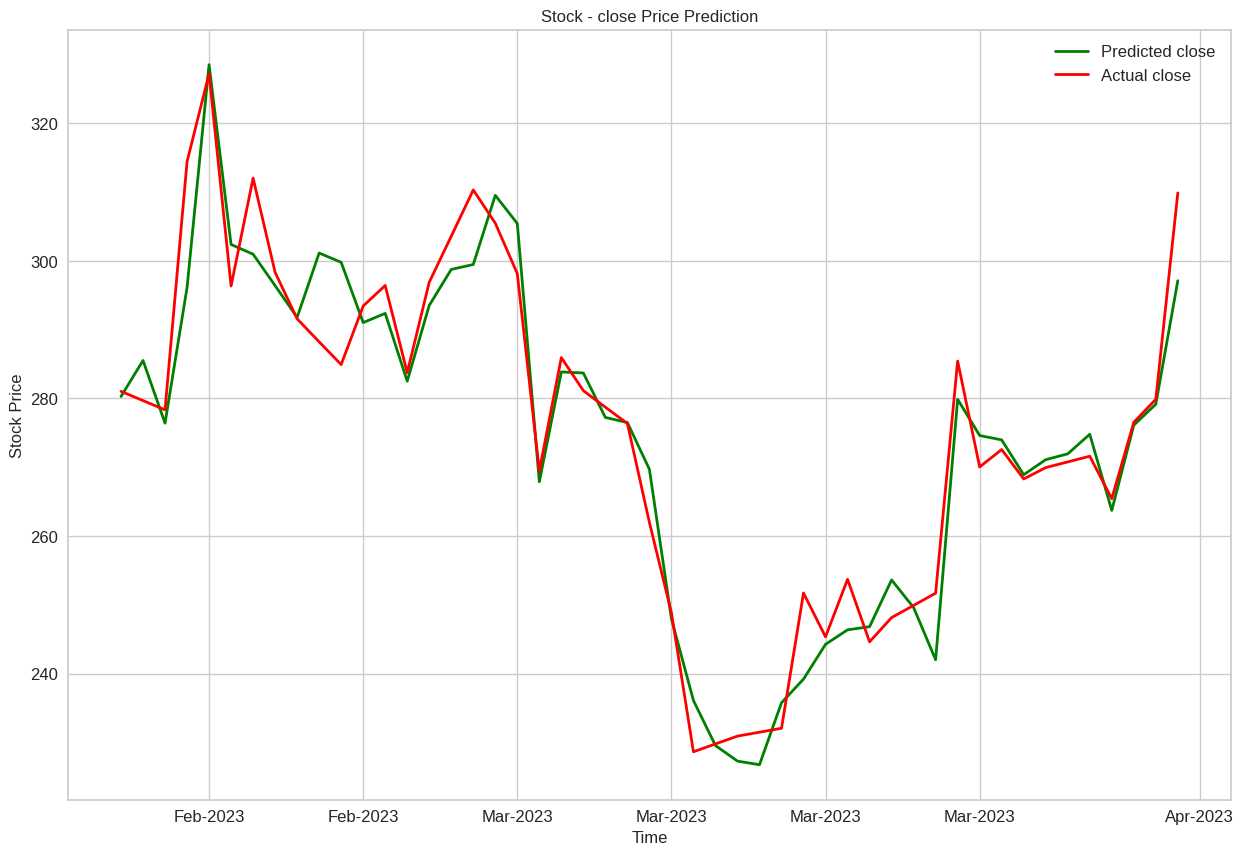

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

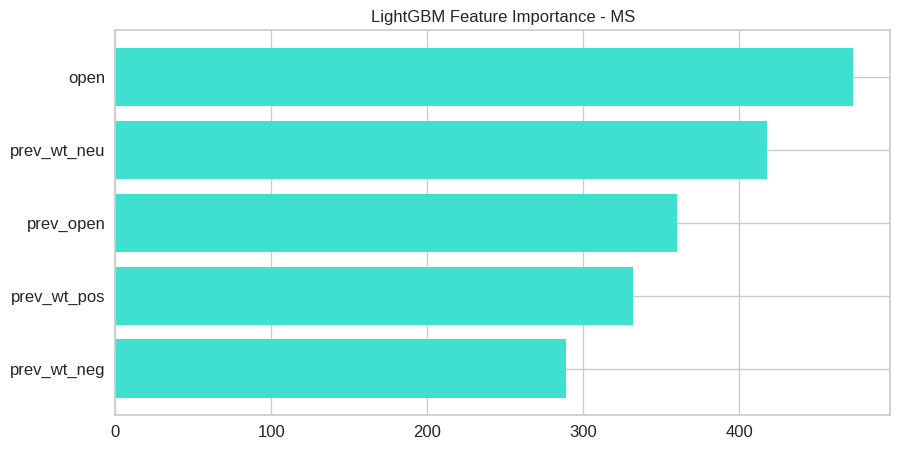

RMSE:			0.072564
MSE:			0.005265
MAE:			0.053786
R2 Score:		0.901612
Adj. R2 Score:		0.898981
Exp. Variance Score:	0.906985
Max Error:		0.267623
Predicted 	 Value
[0.8628195] 	 [0.92596937]
[0.90390444] 	 [0.93576177]
[0.86230042] 	 [0.94516247]
[0.89264704] 	 [0.98942405]
[0.87058542] 	 [1.]
[0.85103578] 	 [0.95064622]
[0.89560755] 	 [0.94829612]
[0.92461126] 	 [0.91147661]
[0.89980158] 	 [0.8930669]
[0.92576753] 	 [0.88366619]
[0.89277338] 	 [0.8742656]
[0.89498006] 	 [0.86055601]
[0.89393427] 	 [0.88679984]
[0.85448805] 	 [0.87739894]
[0.86946079] 	 [0.85781425]
[0.86230042] 	 [0.84802185]
[0.87539344] 	 [0.83822933]
[0.89393427] 	 [0.83039553]
[0.88548668] 	 [0.81825303]
[0.8507258] 	 [0.81394437]
[0.90095785] 	 [0.90207599]
[0.87510634] 	 [0.9028593]
[0.85855106] 	 [0.903251]
[0.91763557] 	 [0.90403427]
[0.92958876] 	 [0.81316082]
[0.91029635] 	 [0.80689384]
[0.92958876] 	 [0.66196611]
[0.69654191] 	 [0.57775169]
[0.54886541] 	 [0.53740688]
[0.58597386] 	 [0.51703868]
[0.56785404]

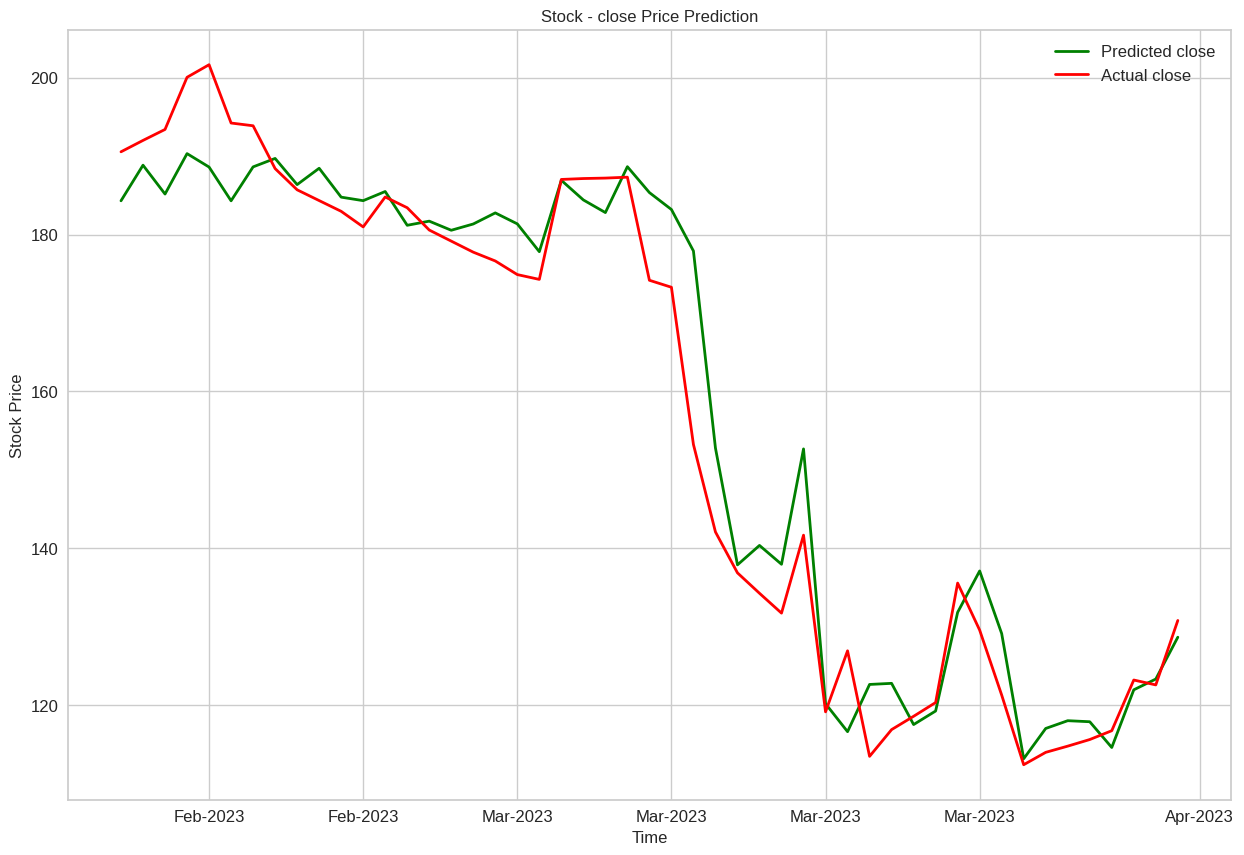

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

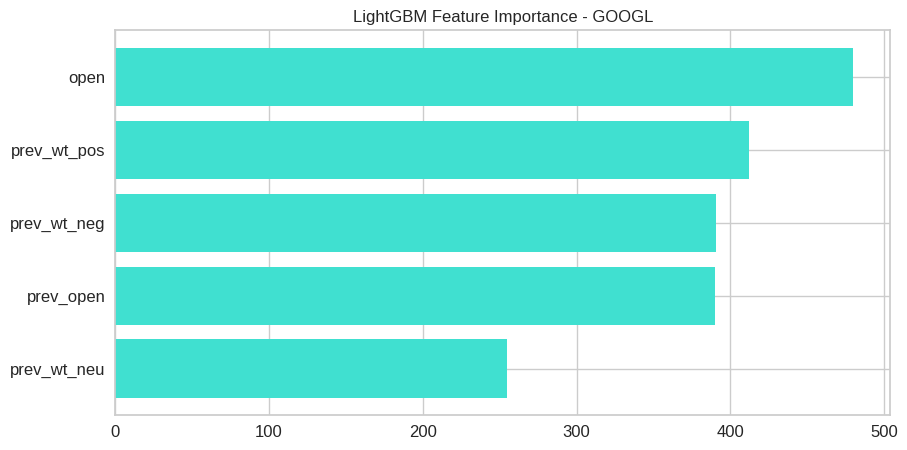

RMSE:			0.045034
MSE:			0.002028
MAE:			0.035698
R2 Score:		0.880818
Adj. R2 Score:		0.877631
Exp. Variance Score:	0.887663
Max Error:		0.106845
Predicted 	 Value
[0.30592025] 	 [0.28874513]
[0.33737225] 	 [0.28900387]
[0.35198999] 	 [0.28926262]
[0.23490984] 	 [0.29107372]
[0.24270195] 	 [0.34954725]
[0.30595921] 	 [0.31254855]
[0.32073403] 	 [0.28253551]
[0.24688655] 	 [0.24941784]
[0.23478116] 	 [0.23285898]
[0.24102606] 	 [0.22457955]
[0.22684915] 	 [0.21630014]
[0.18396749] 	 [0.21267792]
[0.19811326] 	 [0.19301419]
[0.12960746] 	 [0.14747728]
[0.15268943] 	 [0.15705044]
[0.1263897] 	 [0.16196636]
[0.11727158] 	 [0.16662361]
[0.12428226] 	 [0.1715394]
[0.13217726] 	 [0.17930144]
[0.13132617] 	 [0.22173349]
[0.29657826] 	 [0.26442436]
[0.24593386] 	 [0.28357049]
[0.26554272] 	 [0.29314358]
[0.27696231] 	 [0.30271659]
[0.32458174] 	 [0.26985771]
[0.24759771] 	 [0.27994824]
[0.31369775] 	 [0.23001292]
[0.18722474] 	 [0.18628711]
[0.15523861] 	 [0.19249676]
[0.15623681] 	 [0.19560154]

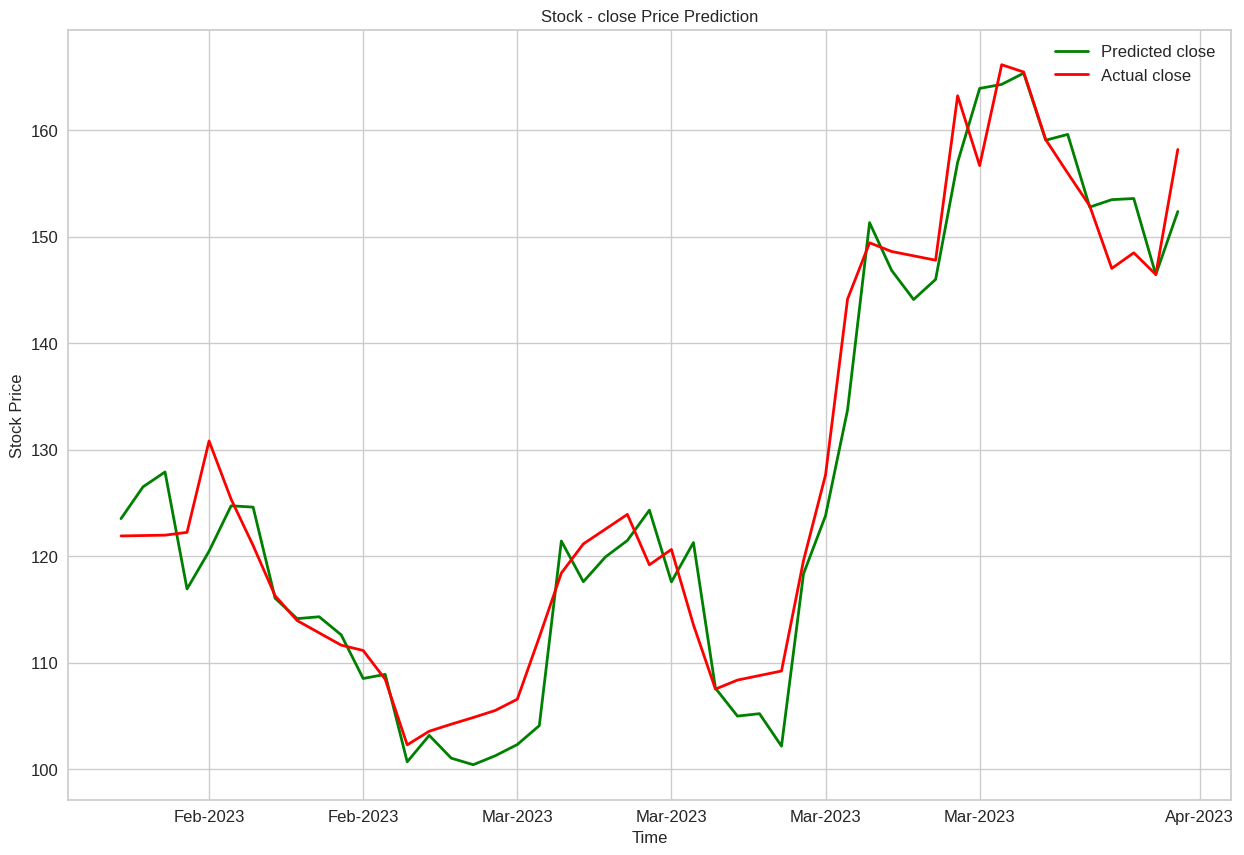

======FINISHED WORKING ON GOOGL======


In [64]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='close')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels)

# **Predicting High value**

In [65]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='high')

both_open_dfs['TSLA']

,date,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,high
0,2022-08-02,294.003326,301.276672,-16.876412,-26.904634,-41.171774,307.833344
1,2022-08-03,305.000000,294.003326,-22.682993,-25.073643,-37.357318,309.549988
2,2022-08-04,311.000000,305.000000,-2.331892,-6.009396,-13.196395,313.606659
3,2022-08-05,302.670013,311.000000,-1.167563,-2.196746,-3.635691,304.606659
4,2022-08-06,298.840000,302.670013,-16.216868,-16.855830,-160.879937,304.900000
...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,193.720000,-14.594635,-21.290344,-30.107518,197.389999
238,2023-03-28,192.000000,194.419998,-232.793960,-281.636459,-465.958222,192.350006
239,2023-03-29,193.130005,192.000000,-13.191043,-12.029059,-33.769606,195.289993
240,2023-03-30,195.580002,193.130005,-50.816797,-73.301693,-115.862161,197.330002


In [66]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='high')

Data dimensions for TSLA: (242, 6) 

Data dimensions for MS: (242, 6) 

Data dimensions for GOOGL: (242, 6) 



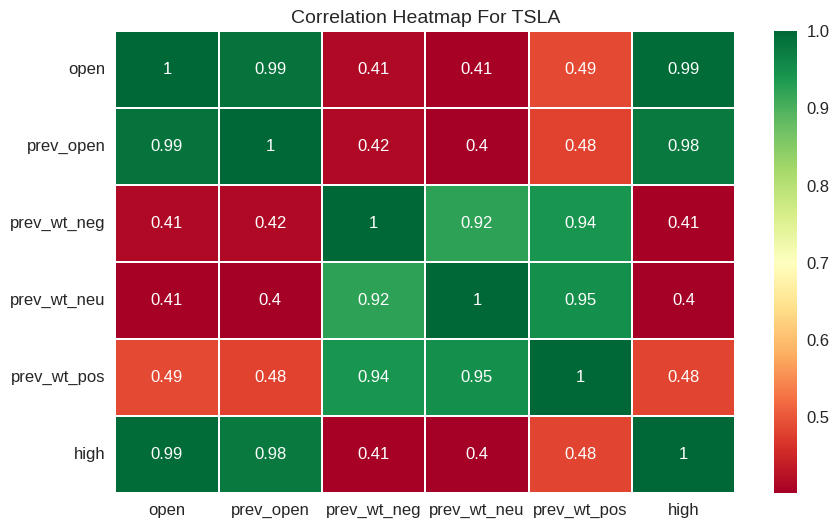

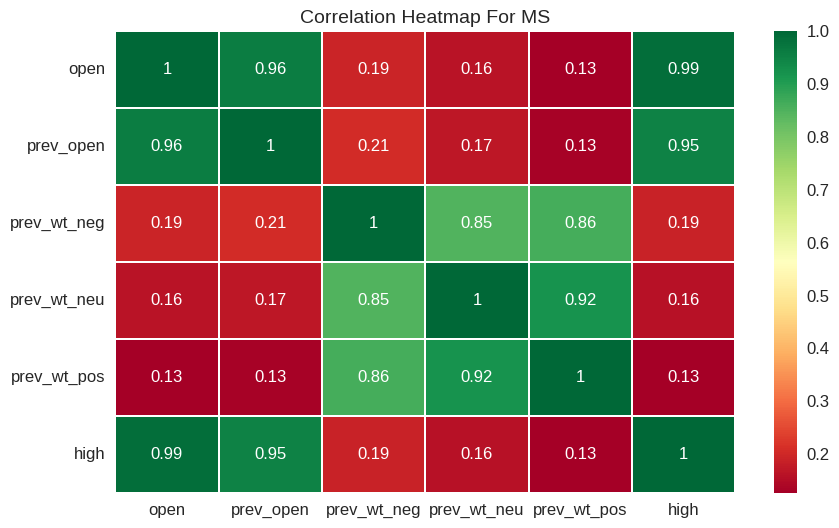

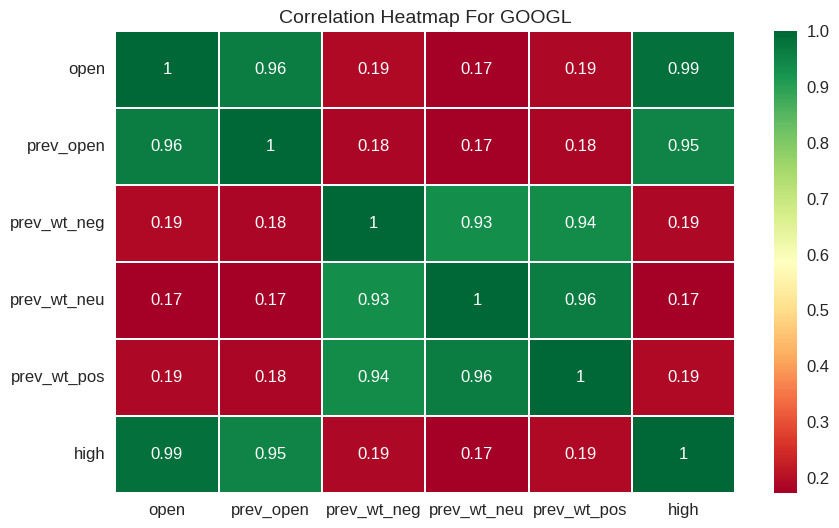

In [67]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

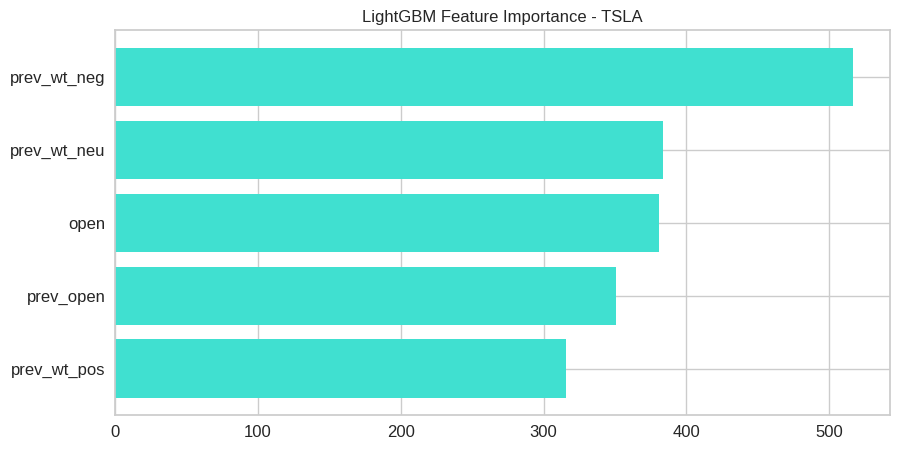

RMSE:			0.022468
MSE:			0.000505
MAE:			0.018143
R2 Score:		0.807373
Adj. R2 Score:		0.802222
Exp. Variance Score:	0.807479
Max Error:		0.069324
Predicted 	 Value
[0.43708724] 	 [0.44106778]
[0.45023372] 	 [0.4288953]
[0.43977476] 	 [0.41667355]
[0.41397762] 	 [0.48330191]
[0.53673658] 	 [0.50715405]
[0.52151275] 	 [0.52188911]
[0.44363244] 	 [0.47650106]
[0.45684914] 	 [0.47965506]
[0.44169819] 	 [0.48123206]
[0.51471108] 	 [0.48202056]
[0.51310421] 	 [0.48275981]
[0.43553082] 	 [0.44471463]
[0.45384125] 	 [0.46023821]
[0.44504598] 	 [0.42342506]
[0.43401754] 	 [0.45235321]
[0.44696231] 	 [0.46684191]
[0.43861429] 	 [0.48133061]
[0.52193779] 	 [0.49025052]
[0.50100775] 	 [0.47039015]
[0.4017778] 	 [0.4041068]
[0.44628668] 	 [0.4372731]
[0.44518768] 	 [0.43264068]
[0.44559264] 	 [0.43032446]
[0.44550908] 	 [0.42800827]
[0.426191] 	 [0.40632444]
[0.38888104] 	 [0.36837784]
[0.35414622] 	 [0.36187267]
[0.32684744] 	 [0.32791785]
[0.29502298] 	 [0.32560166]
[0.30750403] 	 [0.32446819]
[0.

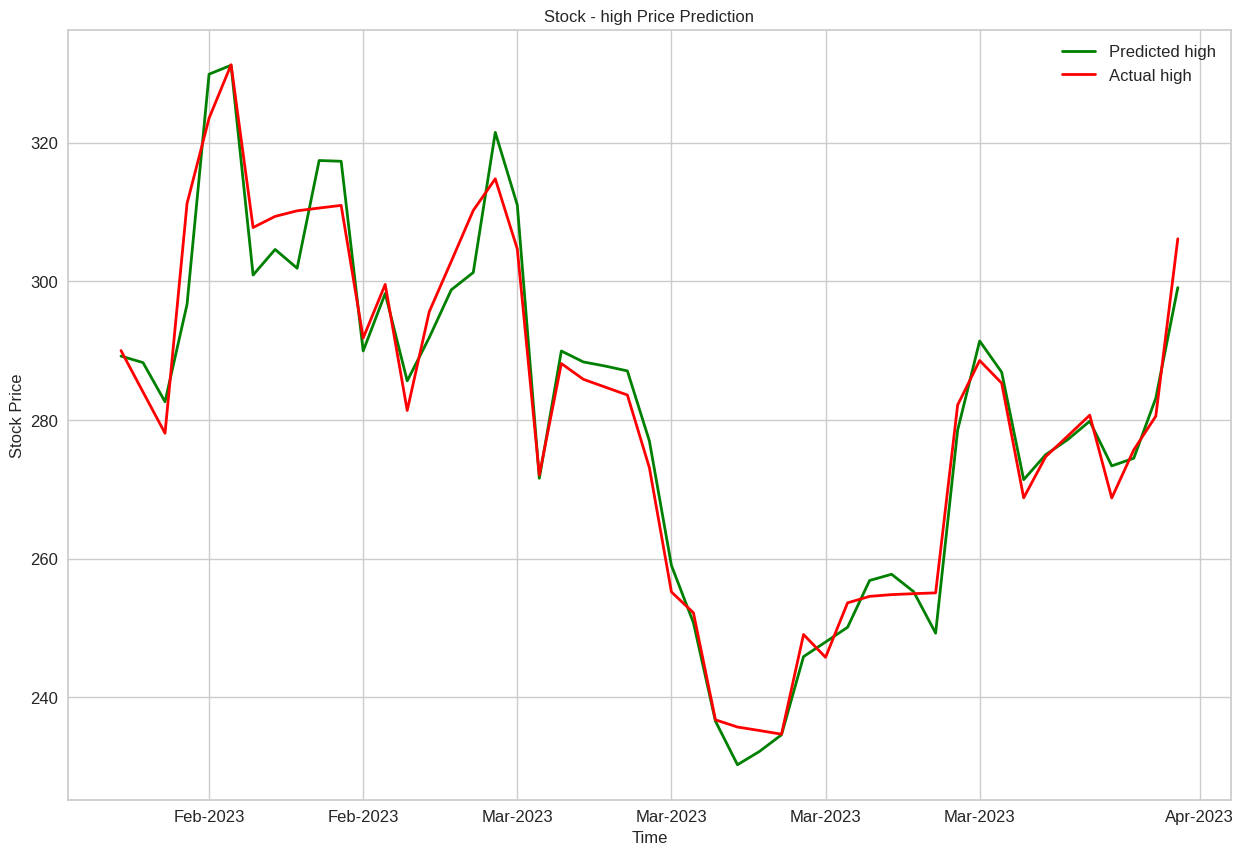

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

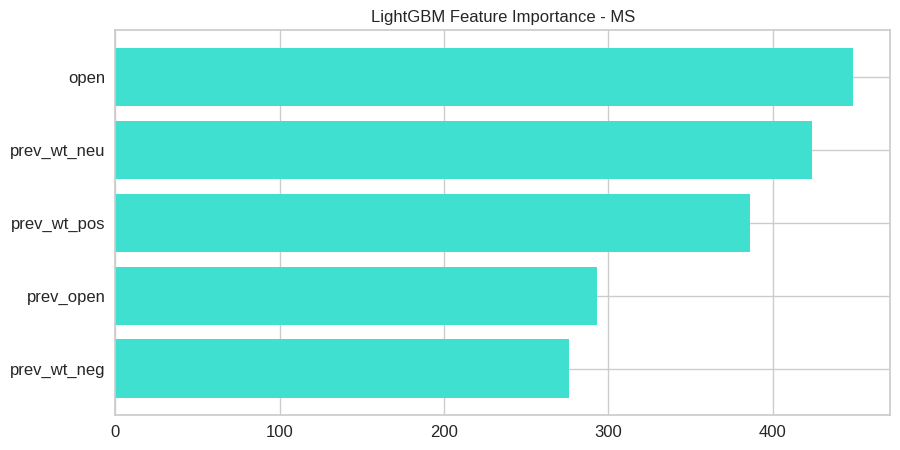

RMSE:			0.053201
MSE:			0.002830
MAE:			0.039262
R2 Score:		0.951663
Adj. R2 Score:		0.950370
Exp. Variance Score:	0.952733
Max Error:		0.143437
Predicted 	 Value
[0.88021321] 	 [0.92194919]
[0.90372] 	 [0.93445458]
[0.89773284] 	 [0.94696006]
[0.91187502] 	 [1.]
[0.89478734] 	 [0.99870638]
[0.89314072] 	 [0.96765847]
[0.91423698] 	 [0.95817157]
[0.92343644] 	 [0.93617946]
[0.91296463] 	 [0.92496773]
[0.92501846] 	 [0.91936186]
[0.91139445] 	 [0.91418722]
[0.92133513] 	 [0.87408372]
[0.92500326] 	 [0.88917635]
[0.90081818] 	 [0.87020286]
[0.8894792] 	 [0.88098324]
[0.88862774] 	 [0.88658911]
[0.91273621] 	 [0.89176388]
[0.92500326] 	 [0.84044856]
[0.9087049] 	 [0.81759392]
[0.90001792] 	 [0.80077637]
[0.91296463] 	 [0.89003896]
[0.89478734] 	 [0.90642525]
[0.88541537] 	 [0.91461844]
[0.93768427] 	 [0.9228115]
[0.92485673] 	 [0.88227699]
[0.92149537] 	 [0.80638211]
[0.92610169] 	 [0.78266485]
[0.71906789] 	 [0.65588626]
[0.56888099] 	 [0.59508409]
[0.55875519] 	 [0.56446744]
[0.53761473

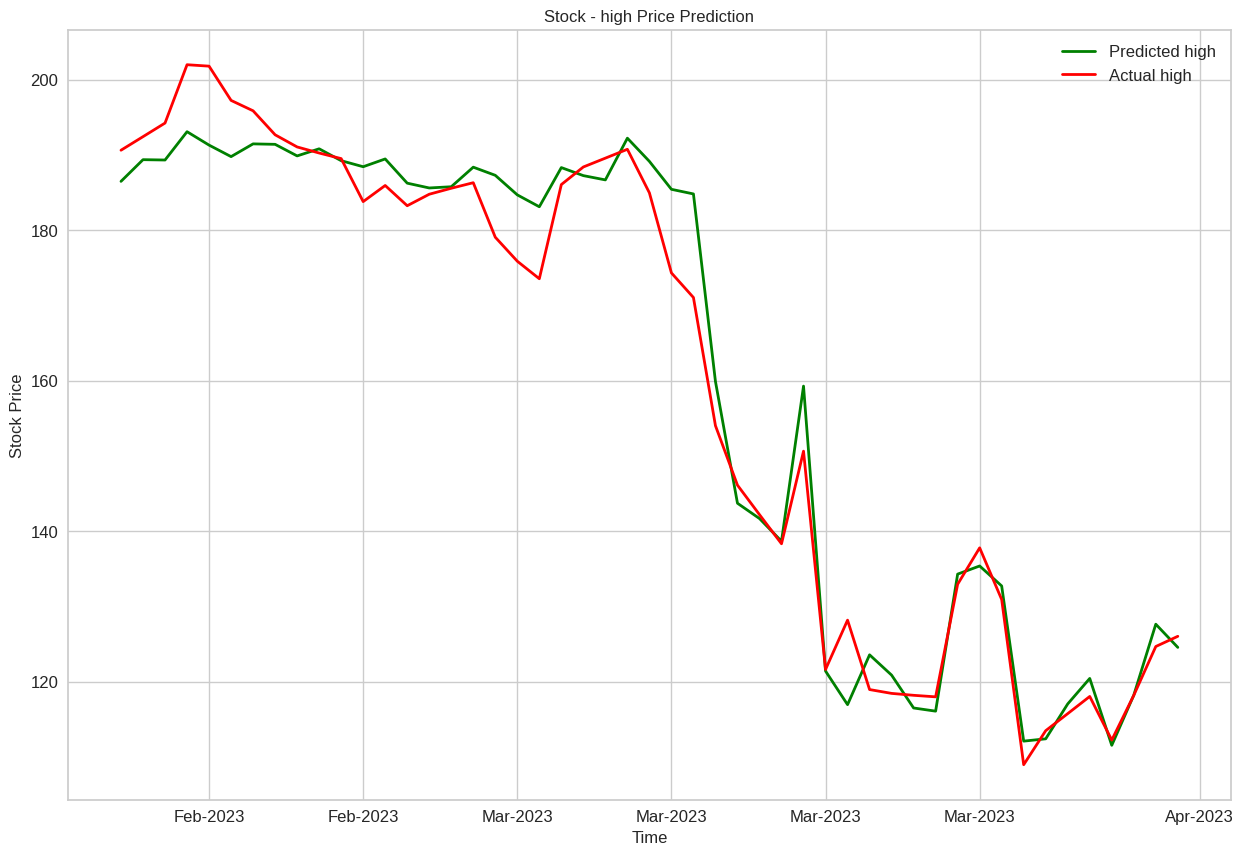

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

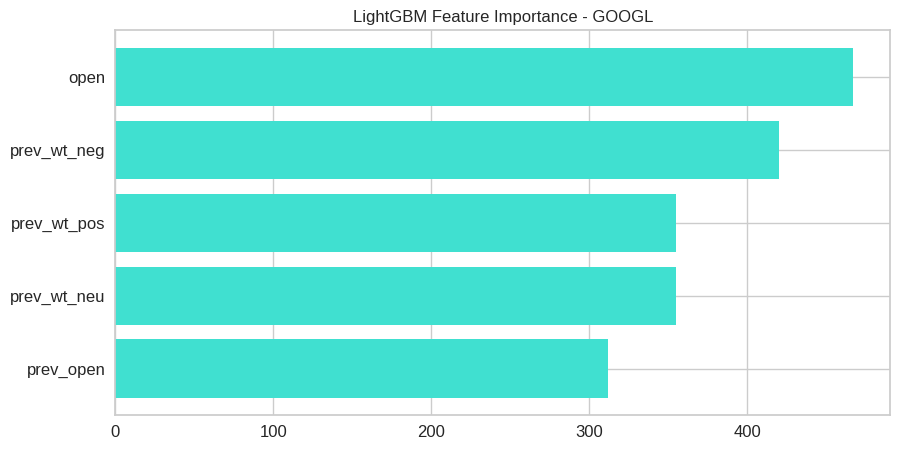

RMSE:			0.037921
MSE:			0.001438
MAE:			0.030034
R2 Score:		0.927733
Adj. R2 Score:		0.925801
Exp. Variance Score:	0.927773
Max Error:		0.101128
Predicted 	 Value
[0.28906388] 	 [0.26315796]
[0.30059721] 	 [0.25229747]
[0.31742948] 	 [0.24171538]
[0.23126087] 	 [0.23196882]
[0.23730211] 	 [0.29518254]
[0.2751826] 	 [0.310777]
[0.30622652] 	 [0.25174047]
[0.24102158] 	 [0.21748823]
[0.21217009] 	 [0.20022285]
[0.19200277] 	 [0.19159015]
[0.20457085] 	 [0.18323588]
[0.14041616] 	 [0.15566704]
[0.15714033] 	 [0.15093301]
[0.10120848] 	 [0.09384577]
[0.1142101] 	 [0.09774444]
[0.12042327] 	 [0.09969375]
[0.08077445] 	 [0.10136471]
[0.10757464] 	 [0.13116139]
[0.0946355] 	 [0.1255918]
[0.12185041] 	 [0.16040104]
[0.22729169] 	 [0.20077988]
[0.20610776] 	 [0.23196888]
[0.24321247] 	 [0.24756342]
[0.25087648] 	 [0.26315798]
[0.29567273] 	 [0.25480368]
[0.24105831] 	 [0.26287945]
[0.28366265] 	 [0.25090508]
[0.15499363] 	 [0.17460327]
[0.11370756] 	 [0.17154003]
[0.14197273] 	 [0.16986919]
[0.

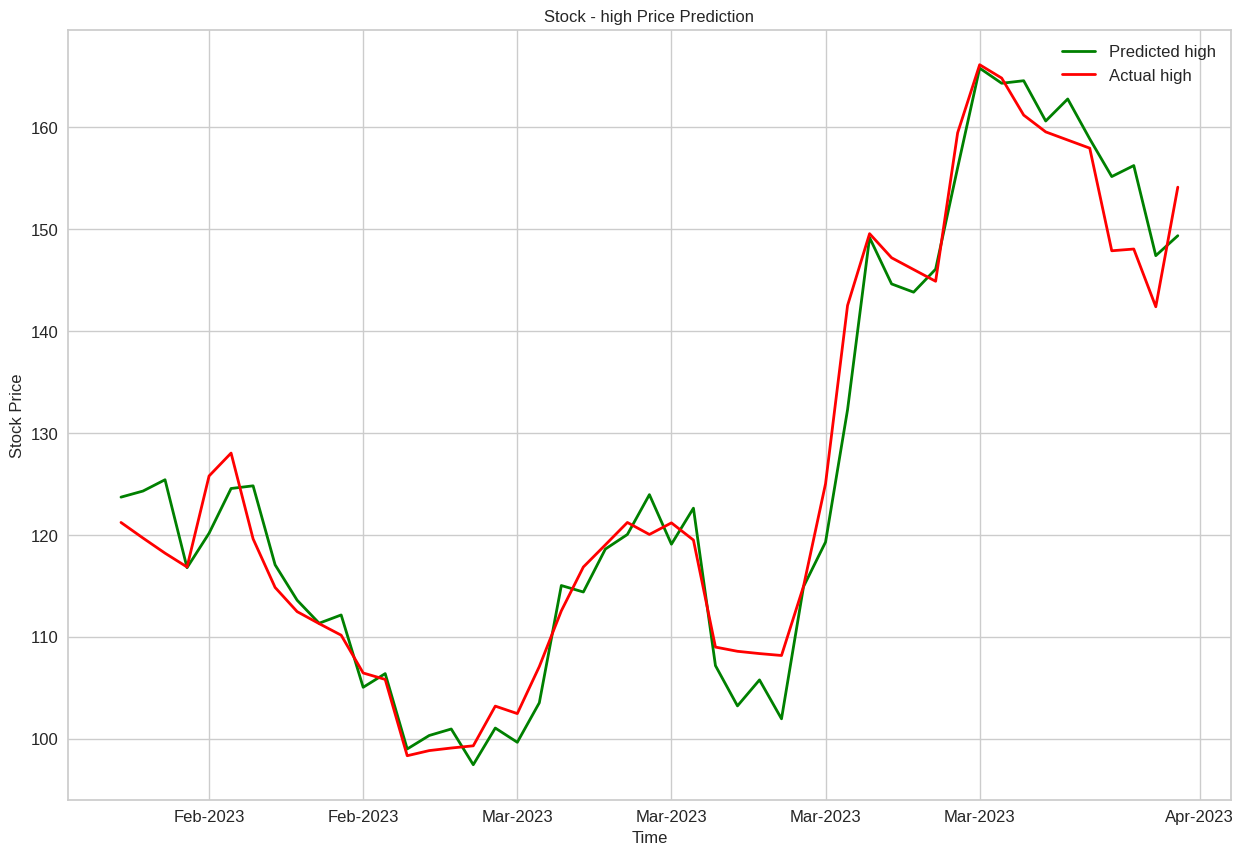

======FINISHED WORKING ON GOOGL======


In [68]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='high')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='high')

# **Predicting Low Value**

In [69]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='low')

both_open_dfs['TSLA']

,date,open,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,low
0,2022-08-02,294.003326,301.276672,-16.876412,-26.904634,-41.171774,292.666656
1,2022-08-03,305.000000,294.003326,-22.682993,-25.073643,-37.357318,301.149994
2,2022-08-04,311.000000,305.000000,-2.331892,-6.009396,-13.196395,305.000000
3,2022-08-05,302.670013,311.000000,-1.167563,-2.196746,-3.635691,285.543335
4,2022-08-06,298.840000,302.670013,-16.216868,-16.855830,-160.879937,287.320000
...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,193.720000,-14.594635,-21.290344,-30.107518,189.940002
238,2023-03-28,192.000000,194.419998,-232.793960,-281.636459,-465.958222,185.429993
239,2023-03-29,193.130005,192.000000,-13.191043,-12.029059,-33.769606,189.440002
240,2023-03-30,195.580002,193.130005,-50.816797,-73.301693,-115.862161,194.419998


In [70]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='low')

Data dimensions for TSLA: (242, 6) 

Data dimensions for MS: (242, 6) 

Data dimensions for GOOGL: (242, 6) 



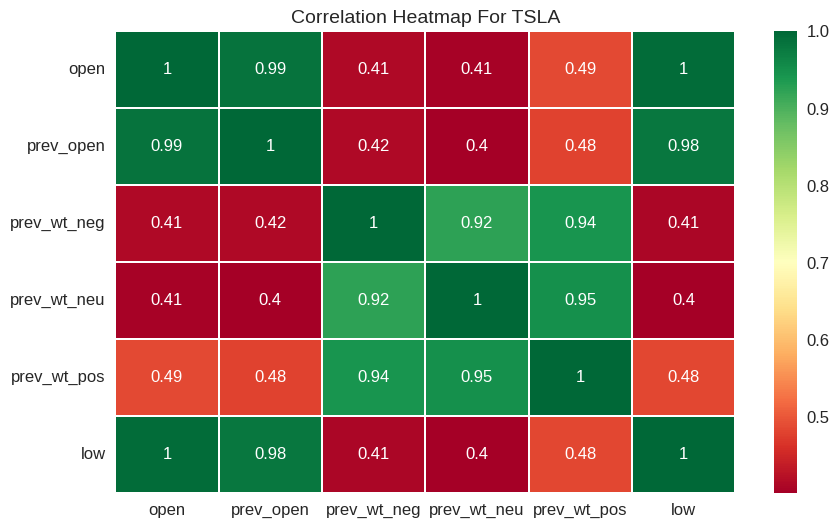

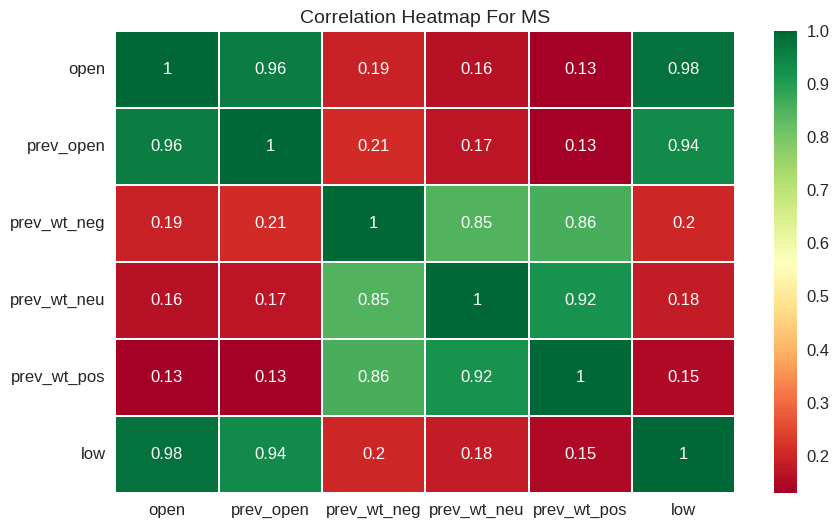

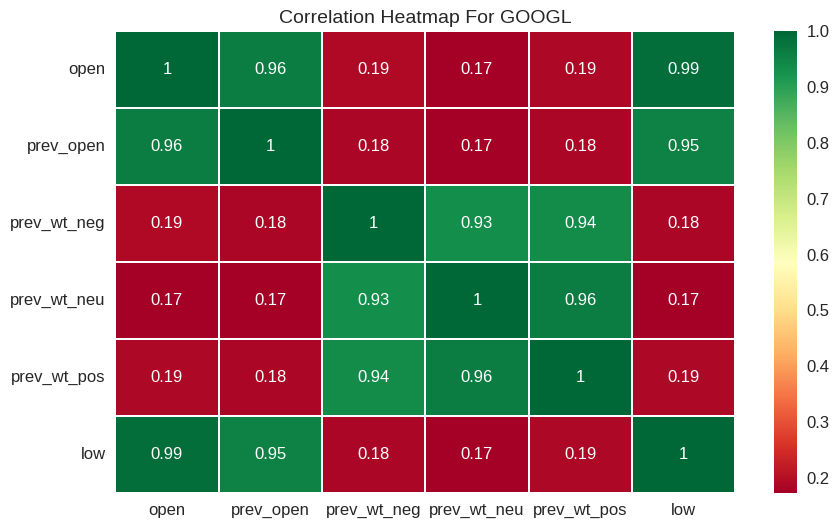

In [71]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

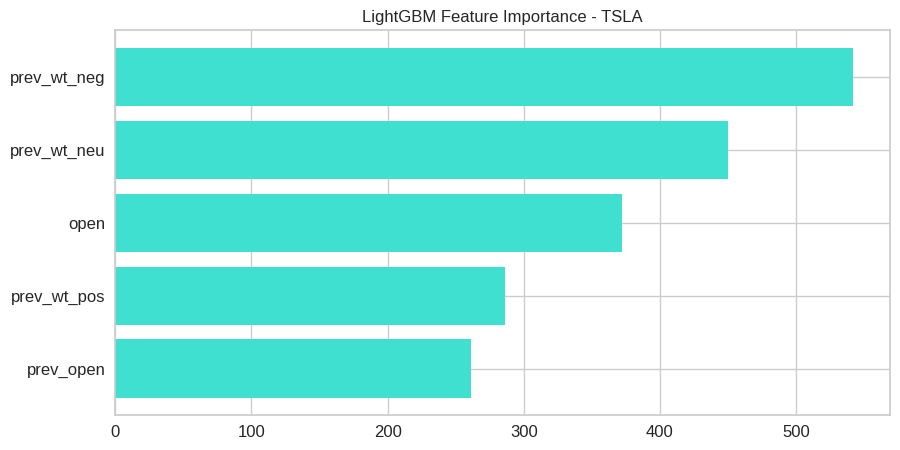

RMSE:			0.017583
MSE:			0.000309
MAE:			0.014007
R2 Score:		0.878302
Adj. R2 Score:		0.875048
Exp. Variance Score:	0.883090
Max Error:		0.051044
Predicted 	 Value
[0.42475422] 	 [0.43401878]
[0.44930814] 	 [0.42754089]
[0.43211131] 	 [0.421063]
[0.41962344] 	 [0.43004372]
[0.52340482] 	 [0.51185164]
[0.49361447] 	 [0.49089662]
[0.44538426] 	 [0.46959811]
[0.44722296] 	 [0.46891106]
[0.44191413] 	 [0.46856754]
[0.49053767] 	 [0.46842031]
[0.48212607] 	 [0.46822402]
[0.43808613] 	 [0.44152724]
[0.4524809] 	 [0.46385635]
[0.43595455] 	 [0.4465329]
[0.4498797] 	 [0.46729159]
[0.45092031] 	 [0.4776464]
[0.43855894] 	 [0.48805026]
[0.49553231] 	 [0.50026995]
[0.48827876] 	 [0.47460377]
[0.39015184] 	 [0.41321098]
[0.44498295] 	 [0.44692551]
[0.45192679] 	 [0.44550232]
[0.43211131] 	 [0.44481527]
[0.44655497] 	 [0.44407916]
[0.42587447] 	 [0.41365271]
[0.39715659] 	 [0.38371697]
[0.36683394] 	 [0.34695981]
[0.33796835] 	 [0.32698635]
[0.31645748] 	 [0.3158954]
[0.31157745] 	 [0.31034993]
[0.3

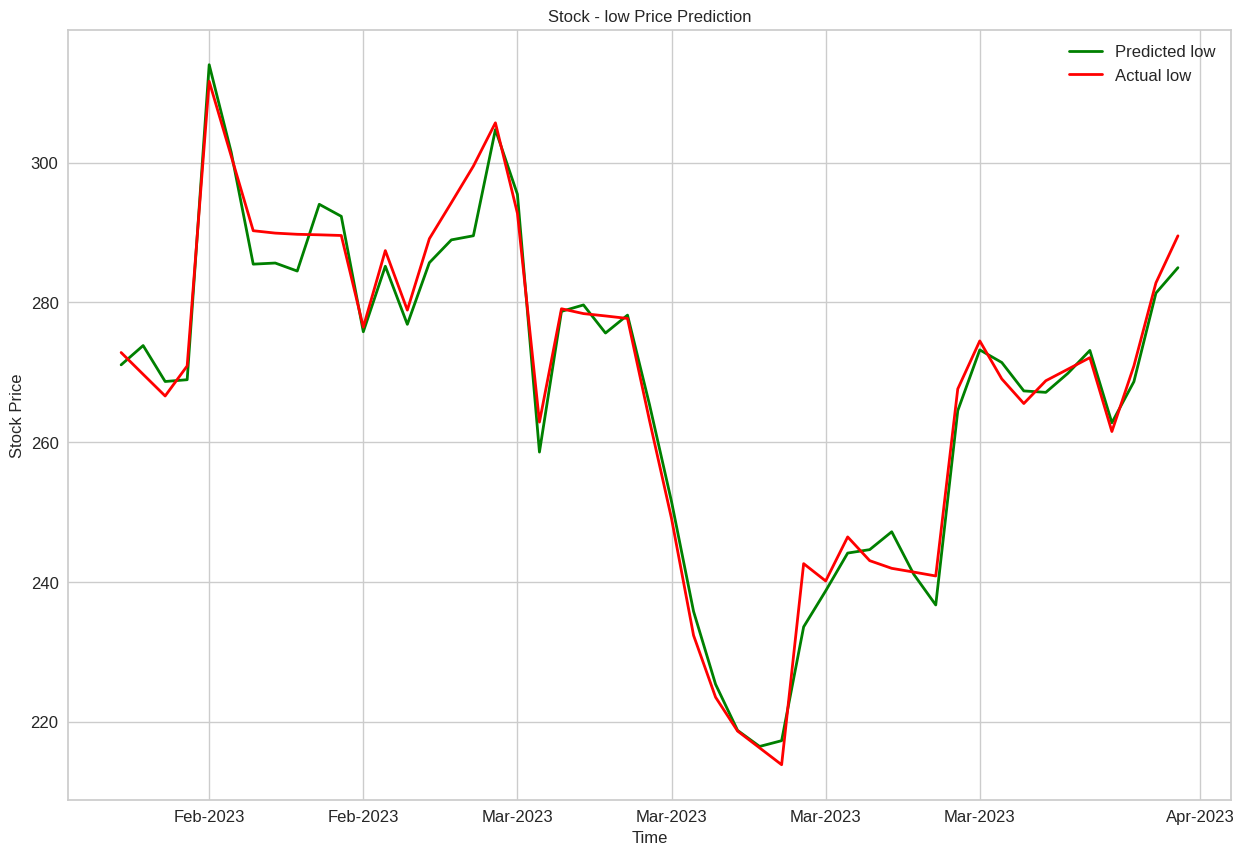

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

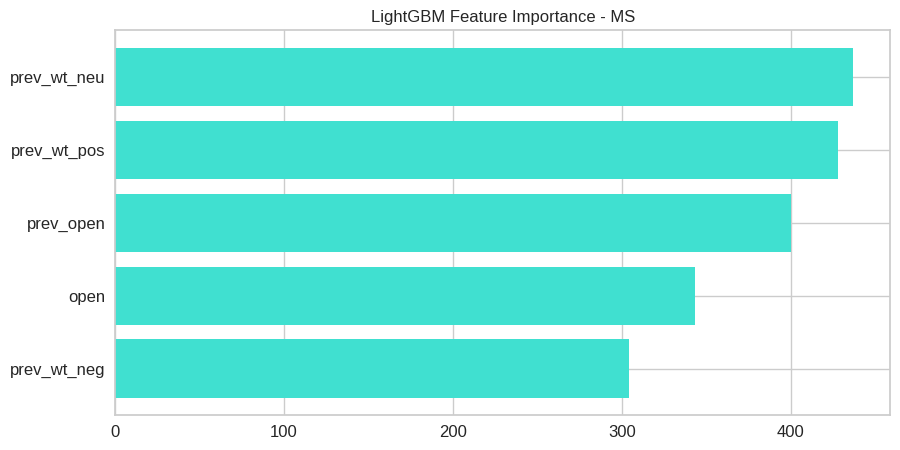

RMSE:			0.067375
MSE:			0.004539
MAE:			0.050541
R2 Score:		0.923066
Adj. R2 Score:		0.921009
Exp. Variance Score:	0.925475
Max Error:		0.230706
Predicted 	 Value
[0.83837263] 	 [0.93395087]
[0.90325234] 	 [0.93999195]
[0.876467] 	 [0.94603319]
[0.89711012] 	 [0.97865489]
[0.85983281] 	 [1.]
[0.8736667] 	 [0.97221096]
[0.8893461] 	 [0.95167149]
[0.92391229] 	 [0.92911801]
[0.89835017] 	 [0.91784133]
[0.92364164] 	 [0.91220299]
[0.88105202] 	 [0.90656465]
[0.88215168] 	 [0.88401141]
[0.89505384] 	 [0.88723307]
[0.87232657] 	 [0.88360859]
[0.87175511] 	 [0.88320581]
[0.86723145] 	 [0.88280307]
[0.88795971] 	 [0.88240041]
[0.89505384] 	 [0.86951278]
[0.89711012] 	 [0.82923892]
[0.88936145] 	 [0.79782535]
[0.89835017] 	 [0.87716461]
[0.84484521] 	 [0.91018929]
[0.86951024] 	 [0.92670158]
[0.93487657] 	 [0.94361652]
[0.9281653] 	 [0.85783332]
[0.91814858] 	 [0.83326626]
[0.91938863] 	 [0.68868295]
[0.72380968] 	 [0.58638759]
[0.58805049] 	 [0.53443419]
[0.59287718] 	 [0.50865892]
[0.5544103

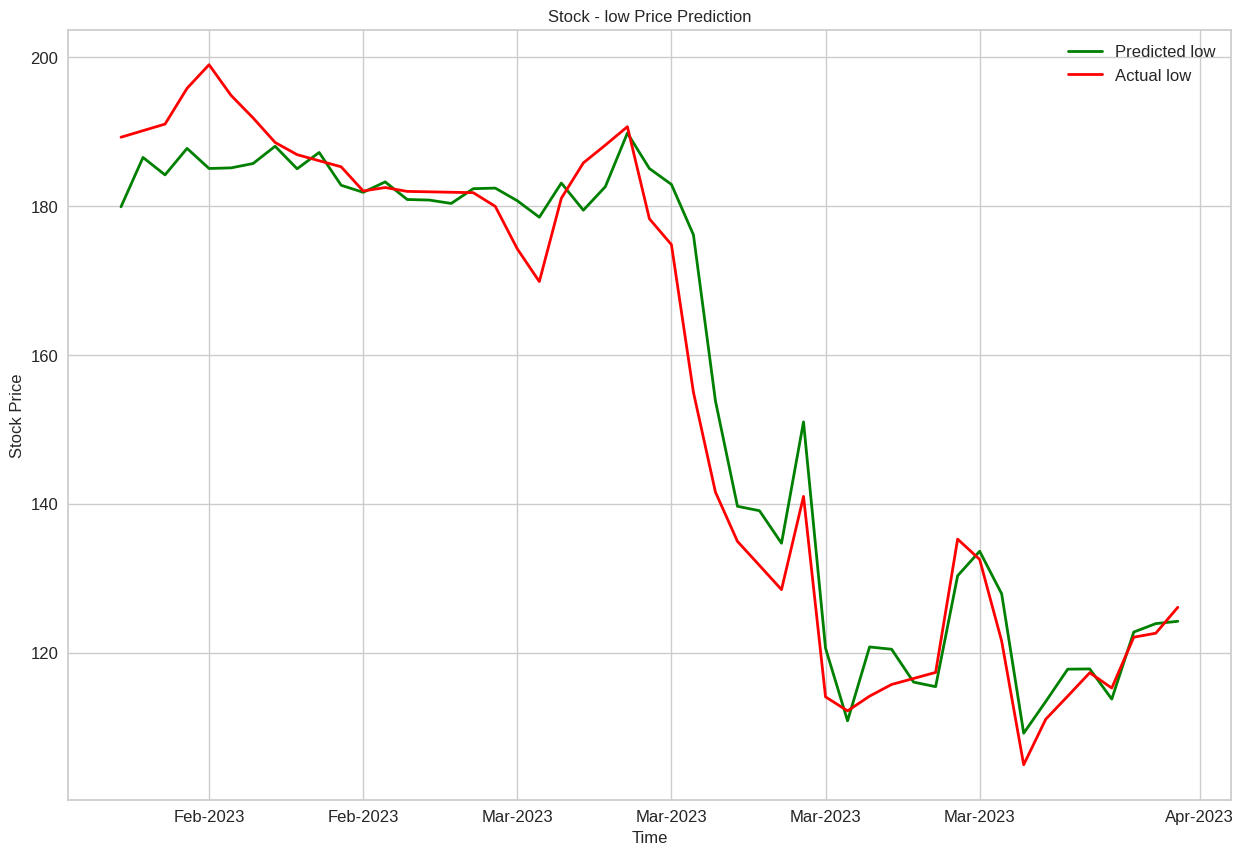

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

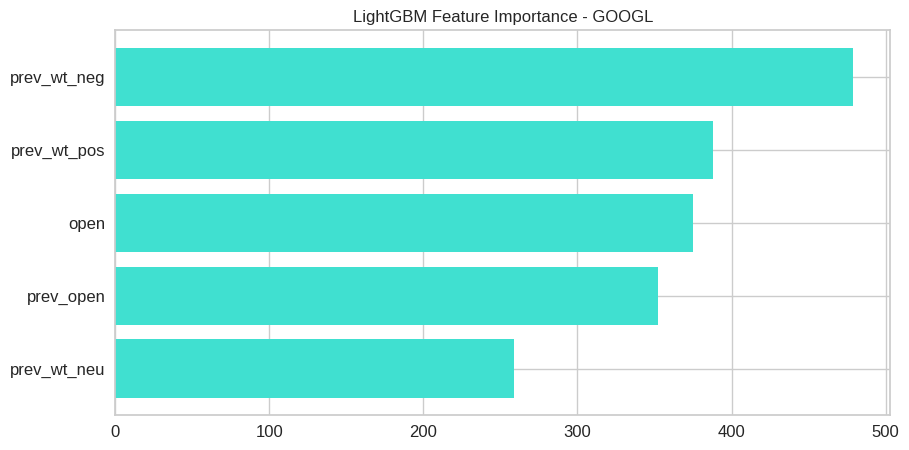

RMSE:			0.028247
MSE:			0.000798
MAE:			0.023746
R2 Score:		0.951678
Adj. R2 Score:		0.950386
Exp. Variance Score:	0.962385
Max Error:		0.062849
Predicted 	 Value
[0.25549033] 	 [0.28686335]
[0.2963089] 	 [0.28418239]
[0.28879608] 	 [0.28150132]
[0.24218065] 	 [0.23914223]
[0.25096444] 	 [0.28981247]
[0.29930659] 	 [0.30563006]
[0.29130993] 	 [0.26461132]
[0.25419111] 	 [0.24477221]
[0.21536282] 	 [0.23485264]
[0.2283823] 	 [0.2297588]
[0.20926213] 	 [0.224665]
[0.17662559] 	 [0.19490628]
[0.18713432] 	 [0.17211811]
[0.11228509] 	 [0.14048272]
[0.14426298] 	 [0.15067034]
[0.12535105] 	 [0.15576417]
[0.10608345] 	 [0.1608579]
[0.11748943] 	 [0.16032181]
[0.13825322] 	 [0.16970513]
[0.10471089] 	 [0.16756031]
[0.23662039] 	 [0.24423593]
[0.21987739] 	 [0.26487944]
[0.25216825] 	 [0.27533521]
[0.23530788] 	 [0.28579097]
[0.28762803] 	 [0.27319041]
[0.25952829] 	 [0.28579097]
[0.26980356] 	 [0.22949076]
[0.17562466] 	 [0.18927629]
[0.15294466] 	 [0.1761395]
[0.14979922] 	 [0.16943709]
[0.1

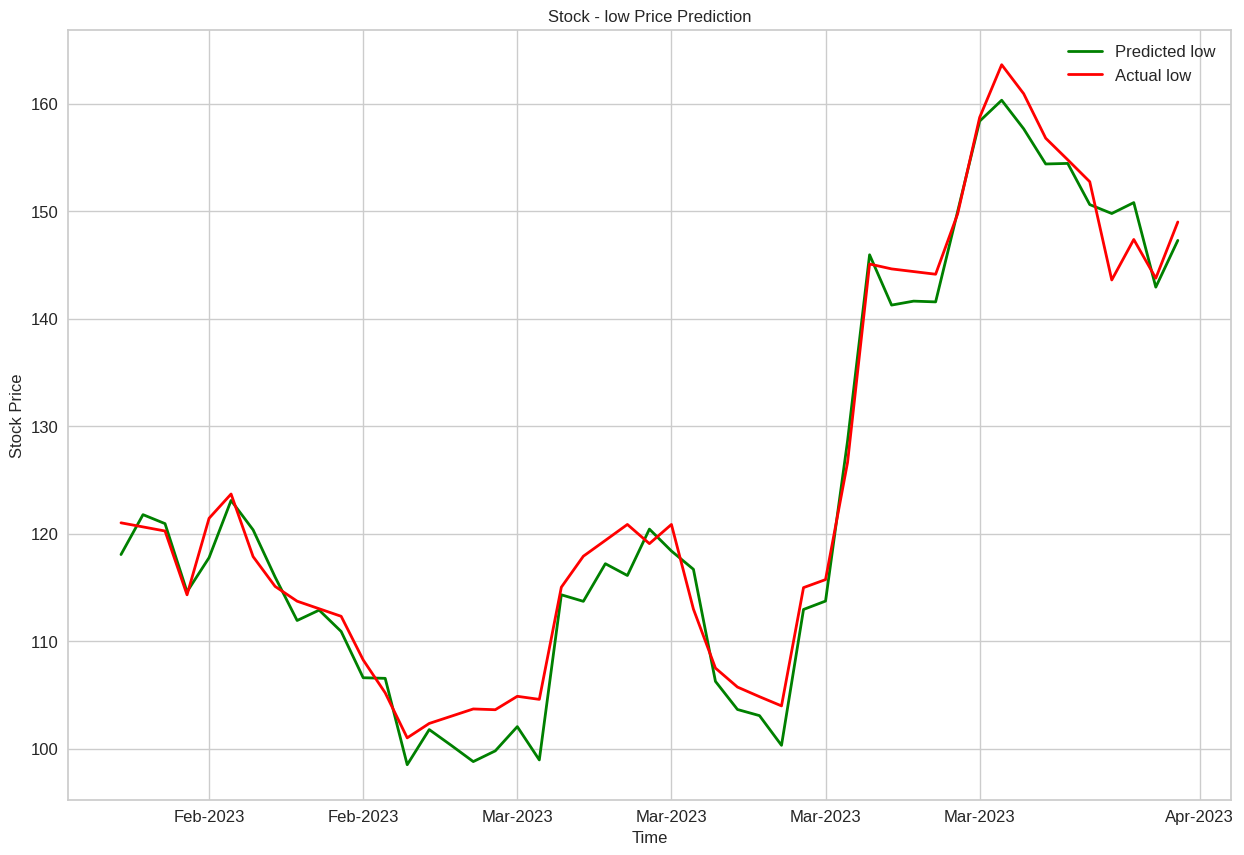

======FINISHED WORKING ON GOOGL======


In [72]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='low')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='low')